In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [55]:
import sys
print(sys.version)
print(lgb.__version__)
print(lgb.__file__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
2.2.3
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/__init__.py


In [56]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [57]:
new_transactions = pd.read_csv('./input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('./input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

historical_transactions[:5]


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [58]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('./input/train.csv')
test = read_data('./input/test.csv')


In [59]:
# creat train_subID

train_subID = train['card_id'].loc[(train['target'] > -4)& (train['target'] < 4)]
train_subID = pd.DataFrame({'card_id':train_subID.values})
#train_subID.head()

In [62]:
target_sub = train['target'].loc[(train['target'] > -4)& (train['target'] < 4)]
print(target_sub.shape)

(191951,)


In [63]:
target = train['target']
del train['target']

In [64]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])


In [65]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)


In [66]:
historical_transactions[:5]


,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,1,0,0,0,0,1,0,0


In [67]:
auth_mean[:5]

,card_id,authorized_flag_sum,authorized_flag_mean
0,C_ID_00007093c1,114.0,0.765101
1,C_ID_0001238066,120.0,0.975610
2,C_ID_0001506ef0,62.0,0.939394
3,C_ID_0001793786,189.0,0.875000
4,C_ID_000183fdda,137.0,0.951389


In [68]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [69]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,...,37,1,0,0,0,0,1,0,0,4
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,...,16,1,0,0,0,0,1,0,0,9
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,...,16,1,0,0,0,0,1,0,0,9
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,...,2,1,0,0,0,0,1,0,0,2
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,...,34,1,0,0,0,0,1,0,0,7


In [70]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
#        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history


In [71]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]


,card_id,hist_transactions_count,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_city_id_nunique,hist_category_3_A_mean,hist_category_2_3.0_mean,hist_subsector_id_nunique,...,hist_purchase_amount_std,hist_category_3_B_mean,hist_category_2_5.0_mean,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_category_2_1.0_mean,hist_merchant_id_nunique,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,35,5.914286,12,1,3.071419,3,0.000000,0.885714,7,...,0.430059,0.828571,0.000000,28858113.0,1.489250e+09,1.518108e+09,0.000000,11,-11,0
1,C_ID_0001238066,3,8.666667,12,2,5.773503,2,0.000000,0.000000,1,...,0.000000,1.000000,0.666667,3609150.0,1.514660e+09,1.518269e+09,0.333333,2,-2,0
2,C_ID_0001506ef0,4,5.500000,12,2,4.725816,1,0.750000,1.000000,4,...,0.016203,0.250000,0.000000,22098875.0,1.496772e+09,1.518871e+09,0.000000,4,-8,0
3,C_ID_0001793786,27,6.481481,9,3,2.375684,8,0.814815,0.111111,11,...,0.498150,0.185185,0.000000,16780236.0,1.488636e+09,1.505416e+09,0.111111,17,-7,-1
4,C_ID_000183fdda,7,8.285714,10,8,0.755929,1,0.000000,1.000000,4,...,0.452741,0.428571,0.000000,6701589.0,1.502099e+09,1.508801e+09,0.000000,4,-6,-4


In [72]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_city_id_nunique,auth_category_3_A_mean,auth_category_2_3.0_mean,auth_subsector_id_nunique,...,auth_purchase_amount_std,auth_category_3_B_mean,auth_category_2_5.0_mean,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_category_2_1.0_mean,auth_merchant_id_nunique,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,114,6.517544,12,1,3.371490,4,0.0,0.780702,13,...,0.237426,0.842105,0.008772,32627654.0,1.487081e+09,1.519708e+09,0.000000,28,-12,0
1,C_ID_0001238066,120,7.275000,12,1,4.895483,18,0.0,0.000000,17,...,0.192614,0.708333,0.150000,13110825.0,1.506638e+09,1.519748e+09,0.783333,65,-5,0
2,C_ID_0001506ef0,62,6.887097,12,1,4.538017,3,1.0,0.967742,12,...,0.484575,0.000000,0.000000,34460275.0,1.484411e+09,1.518871e+09,0.032258,28,-13,0
3,C_ID_0001793786,189,6.698413,10,1,2.301491,9,1.0,0.063492,22,...,0.867916,0.000000,0.000000,24487497.0,1.484994e+09,1.509481e+09,0.042328,114,-9,0
4,C_ID_000183fdda,137,6.810219,12,1,4.538289,9,0.0,0.905109,20,...,0.523760,0.729927,0.007299,15148616.0,1.504444e+09,1.519592e+09,0.051095,71,-5,0


In [73]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]


,card_id,new_transactions_count,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_city_id_nunique,new_category_3_A_mean,new_category_2_3.0_mean,new_subsector_id_nunique,...,new_purchase_amount_std,new_category_3_B_mean,new_category_2_5.0_mean,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_category_2_1.0_mean,new_merchant_id_nunique,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,4.000000,4,4,0.000000,2,0.0,0.50000,2,...,0.010704,1.000000,0.000000,537024.0,1.522754e+09,1.523291e+09,0.500000,2,2,2
1,C_ID_0001238066,26,3.346154,4,3,0.485165,8,0.0,0.00000,9,...,0.173462,0.807692,0.115385,5195343.0,1.519923e+09,1.525118e+09,0.769231,25,1,2
2,C_ID_0001506ef0,2,3.000000,3,3,0.000000,1,1.0,1.00000,2,...,0.011742,0.000000,0.000000,471152.0,1.521239e+09,1.521710e+09,0.000000,1,1,1
3,C_ID_0001793786,31,11.322581,12,11,0.475191,7,1.0,0.16129,14,...,0.947266,0.000000,0.032258,3981096.0,1.510761e+09,1.514742e+09,0.483871,31,1,2
4,C_ID_000183fdda,11,3.272727,4,3,0.467099,2,0.0,1.00000,6,...,0.182861,0.545455,0.000000,5106807.0,1.519994e+09,1.525100e+09,0.000000,11,1,2


In [74]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,0.156374,-0.215325,0.617379,0.273154,0.389389
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,0.013464,-0.729642,0.018235,0.005844,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,0.054207,-0.139516,0.689409,0.278960,0.358014
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,0.190682,-0.190221,0.741501,0.409220,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,0.206594,-0.501372,0.464043,0.100062,0.183985
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,0.163608,-0.578761,0.154732,0.087996,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,0.002568,-0.738228,0.002957,0.002394,0.001692
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,0.086498,-0.597637,0.136971,0.037378,0.074756


In [75]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [76]:
train[:5]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,...,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,authorized_flag_sum,authorized_flag_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,9.538462,12.0,7.0,...,-0.637972,0.119344,-0.664760,0.118497,-0.608962,0.127612,0.051078,0.050203,247.0,0.950000
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,8.545455,12.0,3.0,...,-0.148523,0.438508,-0.292969,0.471576,0.154320,0.970537,0.535838,0.757790,339.0,0.968571
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,3.000000,4.0,2.0,...,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,NaN,NaN,41.0,0.953488
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.000000
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,5.0,1.600000,2.0,1.0,...,3.306644,5.401714,3.239836,5.307234,3.340048,5.448955,0.057857,0.081823,128.0,0.962406


In [77]:
# create train_sub
train_sub = train
train_sub = train_sub.merge(train_subID,on=['card_id'])
train_sub.head()

print('train shape:{0},train_sub shape:{1}'.format(train.shape,train_sub.shape))

train shape:(201917, 112),train_sub shape:(191951, 112)


In [21]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name not in ['card_id', 'first_active_month','feature_1','feature_2','feature_3']:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

#train = normalize(train)
#test = normalize(test)

In [78]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

#features = ['auth_purchase_date_max','new_purchase_date_max','new_purchase_month_mean','new_purchase_amount_max','new_purchase_date_min','auth_purchase_date_ptp', 'new_purchase_date_ptp','hist_category_1_sum','auth_category_1_sum','auth_purchase_date_min']

In [79]:
features[:]

['feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'hist_transactions_count',
 'hist_purchase_month_mean',
 'hist_purchase_month_max',
 'hist_purchase_month_min',
 'hist_purchase_month_std',
 'hist_city_id_nunique',
 'hist_category_3_A_mean',
 'hist_category_2_3.0_mean',
 'hist_subsector_id_nunique',
 'hist_category_2_4.0_mean',
 'hist_category_2_2.0_mean',
 'hist_merchant_category_id_nunique',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_state_id_nunique',
 'hist_category_3_C_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_category_3_B_mean',
 'hist_category_2_5.0_mean',
 'hist_purchase_date_ptp',
 'hist_purchase_date_min',
 'hist_purchase_date_max',
 'hist_category_2_1.0_mean',
 'hist_merchant_id_nunique',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'auth_transactions_count',
 'auth_purchase_month_mean',
 'auth_purchase_month_max',
 'auth_purchase_mon

In [80]:
categorical_feats[:]

['feature_1', 'feature_2', 'feature_3']

In [81]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
#         'device': 'gpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
        }


In [ ]:
def train_lgb(train = train, test = test, target = target): 
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)
    #    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    #    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    
    return feature_importance_df, predictions

#feature_importance_df, predictions = train_lgb(train,test,target)

In [84]:

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

folds_sub = KFold(n_splits=5, shuffle=True, random_state=15)
oof_sub = np.zeros(len(train_sub))
folds_index=0

#fold_sub_sl = folds_sub.split(train_sub.values, target_sub.values)
#print(list(fold_sub_sl)[0][1])

ratio = train_sub.shape[0]/train.shape[0]

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
#    print(trn_idx,val_idx)
#    print((trn_idx*ratio).astype(int),(val_idx*ratio).astype(int))
#    print('*'*20)

trn_idx_sub, val_idx_sub = list(folds_sub.split(train_sub.values, target_sub.values))[folds_index]
print(trn_idx_sub,val_idx_sub)
print(train_sub.shape)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print(trn_idx,val_idx)
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    
    print('train sub')
    trn_idx_sub, val_idx_sub = list(folds_sub.split(train_sub.values, target_sub.values))[folds_index]
    folds_index += 1
#    trn_idx_sub = (trn_idx*ratio).astype(int)
#    val_idx_sub = (val_idx*ratio).astype(int)
    trn_data_sub = lgb.Dataset(train_sub.iloc[trn_idx_sub][features], label=target_sub.iloc[trn_idx_sub], categorical_feature=categorical_feats)
    val_data_sub = lgb.Dataset(train_sub.iloc[val_idx_sub][features], label=target_sub.iloc[val_idx_sub], categorical_feature=categorical_feats)

    clf_sub = lgb.train(param, trn_data_sub, num_round, valid_sets = [trn_data_sub, val_data_sub], verbose_eval=100, early_stopping_rounds = 200)
    oof_sub[val_idx_sub] = clf_sub.predict(train_sub.iloc[val_idx_sub][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    pre = clf.predict(test[features], num_iteration=clf.best_iteration)
    
    pre1 = pre.loc[(pre['target'] > -4) & (pre['target'] < 4)]
    pre2 = pre.loc[(pre['target'] < -4) & (pre['target'] > 4)]
    
    test_sub = pre1['card_id'].merge(test, on='card_id')
    print('test_sub shape:',test_sub)
    
    pre_sub = clf_sub.predict(test_sub[features], num_iteration=clf_sub.best_iteration)
    
    pre2.concat(pre_sub,ignore_index=True)
    predictions += (pre2  / folds.n_splits)

#    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))



#feature_importance_df, predictions = train_lgb(train,test,target)

[     0      1      2 ... 191948 191949 191950] [     4      5      6 ... 191941 191942 191946]
(191951, 112)
[     0      1      2 ... 201914 201915 201916] [     4      5      6 ... 201904 201907 201911]
fold n°0


/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73671	valid_1's rmse: 3.79205
[200]	training's rmse: 3.67842	valid_1's rmse: 3.74762
[300]	training's rmse: 3.64107	valid_1's rmse: 3.7248
[400]	training's rmse: 3.61495	valid_1's rmse: 3.71133
[500]	training's rmse: 3.59504	valid_1's rmse: 3.70331
[600]	training's rmse: 3.57895	valid_1's rmse: 3.69683
[700]	training's rmse: 3.56604	valid_1's rmse: 3.69284
[800]	training's rmse: 3.55451	valid_1's rmse: 3.69016
[900]	training's rmse: 3.54374	valid_1's rmse: 3.68815
[1000]	training's rmse: 3.5339	valid_1's rmse: 3.68621
[1100]	training's rmse: 3.52452	valid_1's rmse: 3.6849
[1200]	training's rmse: 3.51535	valid_1's rmse: 3.68376
[1300]	training's rmse: 3.50665	valid_1's rmse: 3.68294
[1400]	training's rmse: 3.49786	valid_1's rmse: 3.68224
[1500]	training's rmse: 3.48979	valid_1's rmse: 3.68196
[1600]	training's rmse: 3.48227	valid_1's rmse: 3.68148
[1700]	training's rmse: 3.4744	valid_1's rmse: 3.6812

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.30666	valid_1's rmse: 1.31484
[200]	training's rmse: 1.28123	valid_1's rmse: 1.29188
[300]	training's rmse: 1.26722	valid_1's rmse: 1.28014
[400]	training's rmse: 1.25822	valid_1's rmse: 1.27334
[500]	training's rmse: 1.25168	valid_1's rmse: 1.26892
[600]	training's rmse: 1.24655	valid_1's rmse: 1.26585
[700]	training's rmse: 1.24231	valid_1's rmse: 1.26364
[800]	training's rmse: 1.23882	valid_1's rmse: 1.262
[900]	training's rmse: 1.23579	valid_1's rmse: 1.26082
[1000]	training's rmse: 1.2331	valid_1's rmse: 1.25989
[1100]	training's rmse: 1.23075	valid_1's rmse: 1.25919
[1200]	training's rmse: 1.22846	valid_1's rmse: 1.25857
[1300]	training's rmse: 1.22634	valid_1's rmse: 1.25808
[1400]	training's rmse: 1.22434	valid_1's rmse: 1.25766
[1500]	training's rmse: 1.22246	valid_1's rmse: 1.25733
[1600]	training's rmse: 1.22066	valid_1's rmse: 1.257
[1700]	training's rmse: 1.21895	valid_1's rmse: 1.25677

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

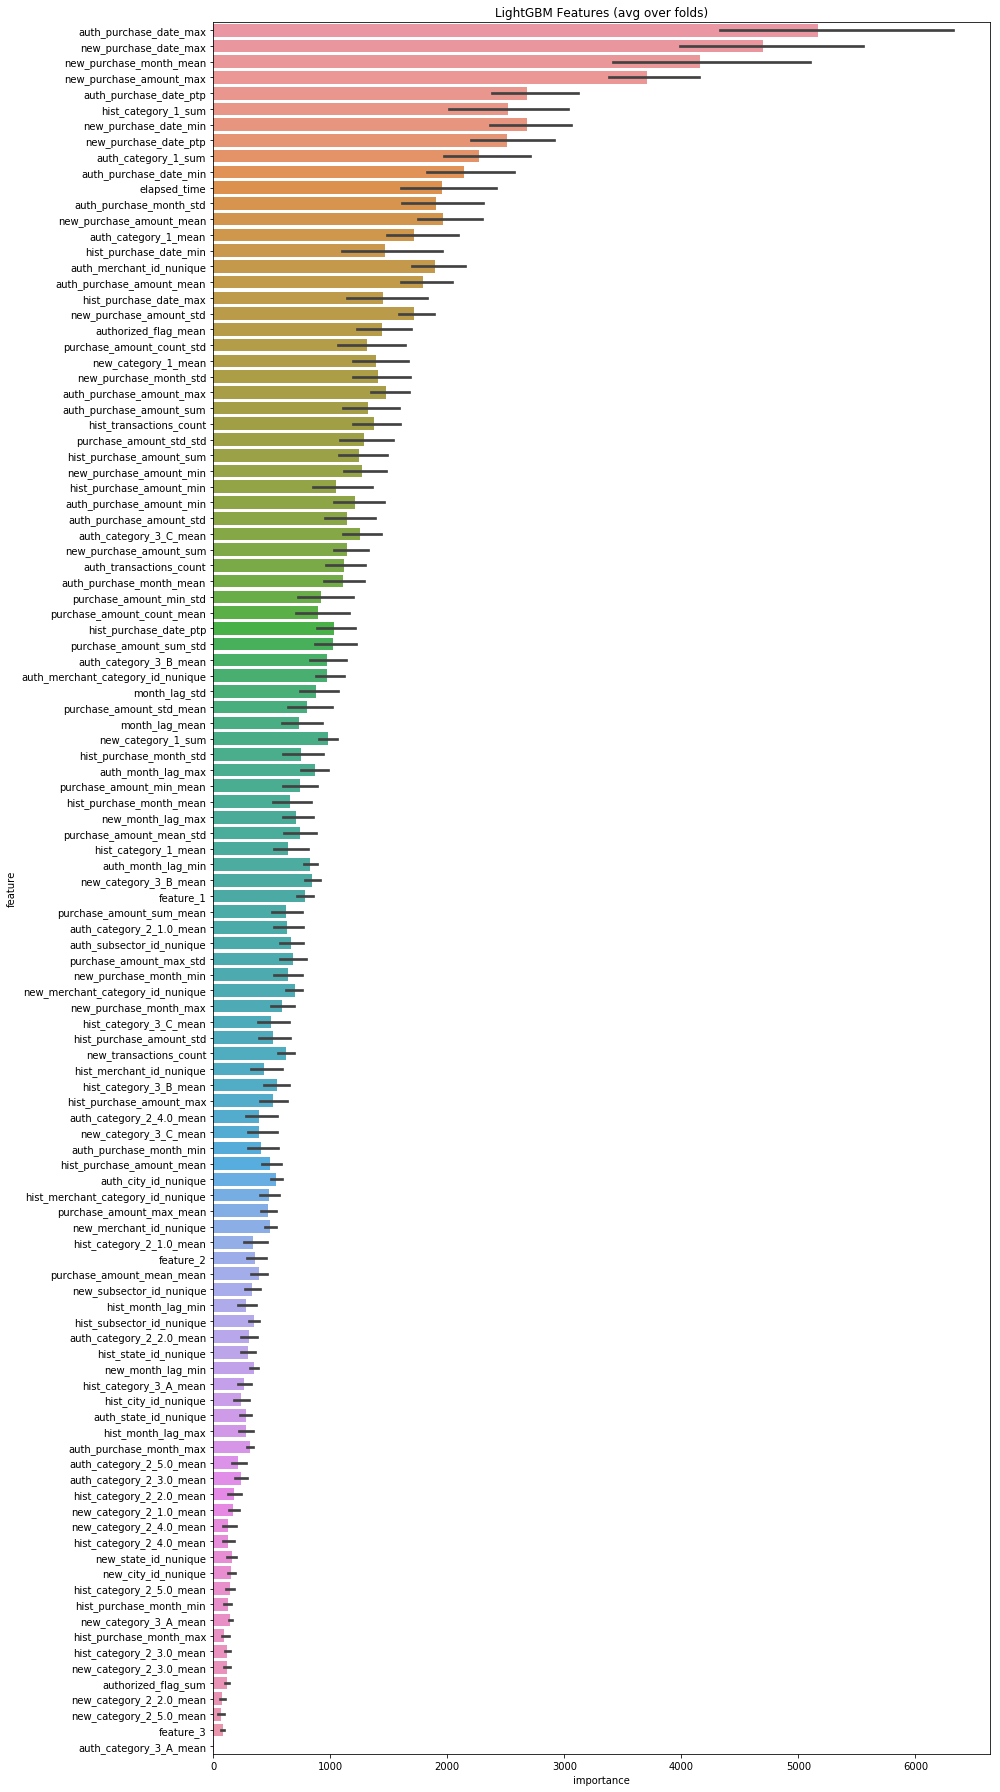

In [31]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [33]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)


In [104]:
first_result = pd.read_csv('./submit.csv')

In [105]:
target_sub = train_sub['target']
#train_subID.head()
train_sub = train_subID
train_sub = train_sub.merge(train,on=['card_id'])
print(train.shape,train_sub.shape)
print(target_sub.shape)
train_sub.head()

(201917, 112) (191951, 112)
(191951,)


,card_id,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_month_lag_min,hist_month_lag_max,hist_category_3_C_mean,...,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,authorized_flag_sum,authorized_flag_mean
0,C_ID_92a2005557,2017-06-01,5,2,1,245,13.0,-7.0,-2.0,0.000000,...,-0.637972,0.119344,-0.664760,0.118497,-0.608962,0.127612,0.051078,0.050203,247.0,0.950000
1,C_ID_3d0044924f,2017-01-01,4,1,0,396,11.0,-10.0,-1.0,0.636364,...,-0.148523,0.438508,-0.292969,0.471576,0.154320,0.970537,0.535838,0.757790,339.0,0.968571
2,C_ID_d639edf6cd,2016-08-01,2,2,0,549,2.0,-12.0,-10.0,0.000000,...,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,NaN,NaN,41.0,0.953488
3,C_ID_186d6a6901,2017-09-01,4,3,0,153,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.000000
4,C_ID_cdbd2c0db2,2017-11-01,1,3,0,92,5.0,-1.0,0.0,0.600000,...,3.306644,5.401714,3.239836,5.307234,3.340048,5.448955,0.057857,0.081823,128.0,0.962406


In [77]:
first_subID = first_result['card_id'].loc[(first_result['target'] > -4)& (first_result['target'] < 4)]
first_subID = pd.DataFrame({'card_id':first_subID.values})
#train_subID.head()
test_sub = test
test_sub = test_sub.merge(first_subID,on=['card_id'])
print(test.shape,test_sub.shape)

(123623, 112) (121752, 112)


In [110]:
feature_importance_df, predictions = train_lgb(train_sub,test_sub,target_sub)

fold n°0


/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.30661	valid_1's rmse: 1.3148
[200]	training's rmse: 1.2812	valid_1's rmse: 1.29184
[300]	training's rmse: 1.26723	valid_1's rmse: 1.28017
[400]	training's rmse: 1.25823	valid_1's rmse: 1.2733
[500]	training's rmse: 1.25169	valid_1's rmse: 1.26883
[600]	training's rmse: 1.24653	valid_1's rmse: 1.26578
[700]	training's rmse: 1.24227	valid_1's rmse: 1.26355
[800]	training's rmse: 1.2388	valid_1's rmse: 1.26196
[900]	training's rmse: 1.23576	valid_1's rmse: 1.26078
[1000]	training's rmse: 1.23306	valid_1's rmse: 1.25986
[1100]	training's rmse: 1.23072	valid_1's rmse: 1.25921
[1200]	training's rmse: 1.2284	valid_1's rmse: 1.25861
[1300]	training's rmse: 1.22625	valid_1's rmse: 1.25809
[1400]	training's rmse: 1.22423	valid_1's rmse: 1.25768
[1500]	training's rmse: 1.22234	valid_1's rmse: 1.25735
[1600]	training's rmse: 1.22052	valid_1's rmse: 1.257
[1700]	training's rmse: 1.21884	valid_1's rmse: 1.2568
[1

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.30918	valid_1's rmse: 1.30453
[200]	training's rmse: 1.28352	valid_1's rmse: 1.28123
[300]	training's rmse: 1.26941	valid_1's rmse: 1.26958
[400]	training's rmse: 1.26026	valid_1's rmse: 1.26294
[500]	training's rmse: 1.2536	valid_1's rmse: 1.2588
[600]	training's rmse: 1.24844	valid_1's rmse: 1.2561
[700]	training's rmse: 1.24423	valid_1's rmse: 1.25417
[800]	training's rmse: 1.24063	valid_1's rmse: 1.2528
[900]	training's rmse: 1.23755	valid_1's rmse: 1.25177
[1000]	training's rmse: 1.23484	valid_1's rmse: 1.25103
[1100]	training's rmse: 1.23223	valid_1's rmse: 1.2504
[1200]	training's rmse: 1.22992	valid_1's rmse: 1.24989
[1300]	training's rmse: 1.22782	valid_1's rmse: 1.2495
[1400]	training's rmse: 1.22567	valid_1's rmse: 1.24913
[1500]	training's rmse: 1.22375	valid_1's rmse: 1.24888
[1600]	training's rmse: 1.22195	valid_1's rmse: 1.24865
[1700]	training's rmse: 1.22002	valid_1's rmse: 1.24845


/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.30818	valid_1's rmse: 1.30773
[200]	training's rmse: 1.2827	valid_1's rmse: 1.28474
[300]	training's rmse: 1.26861	valid_1's rmse: 1.27319
[400]	training's rmse: 1.25945	valid_1's rmse: 1.2666
[500]	training's rmse: 1.2529	valid_1's rmse: 1.26261
[600]	training's rmse: 1.24775	valid_1's rmse: 1.25997
[700]	training's rmse: 1.24344	valid_1's rmse: 1.25802
[800]	training's rmse: 1.23983	valid_1's rmse: 1.25661
[900]	training's rmse: 1.23671	valid_1's rmse: 1.25554
[1000]	training's rmse: 1.23394	valid_1's rmse: 1.25469
[1100]	training's rmse: 1.23146	valid_1's rmse: 1.25407
[1200]	training's rmse: 1.22921	valid_1's rmse: 1.25359
[1300]	training's rmse: 1.2271	valid_1's rmse: 1.25322
[1400]	training's rmse: 1.22517	valid_1's rmse: 1.25294
[1500]	training's rmse: 1.22329	valid_1's rmse: 1.25271
[1600]	training's rmse: 1.22143	valid_1's rmse: 1.25249
[1700]	training's rmse: 1.21971	valid_1's rmse: 1.2523

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.30807	valid_1's rmse: 1.30834
[200]	training's rmse: 1.28252	valid_1's rmse: 1.28582
[300]	training's rmse: 1.26834	valid_1's rmse: 1.27442
[400]	training's rmse: 1.25921	valid_1's rmse: 1.26789
[500]	training's rmse: 1.25262	valid_1's rmse: 1.26385
[600]	training's rmse: 1.24746	valid_1's rmse: 1.2611
[700]	training's rmse: 1.24323	valid_1's rmse: 1.25911
[800]	training's rmse: 1.23966	valid_1's rmse: 1.25766
[900]	training's rmse: 1.23673	valid_1's rmse: 1.25662
[1000]	training's rmse: 1.23398	valid_1's rmse: 1.25578
[1100]	training's rmse: 1.23162	valid_1's rmse: 1.25513
[1200]	training's rmse: 1.22946	valid_1's rmse: 1.25462
[1300]	training's rmse: 1.22738	valid_1's rmse: 1.25418
[1400]	training's rmse: 1.22538	valid_1's rmse: 1.2538
[1500]	training's rmse: 1.22357	valid_1's rmse: 1.25351
[1600]	training's rmse: 1.22177	valid_1's rmse: 1.25327
[1700]	training's rmse: 1.21999	valid_1's rmse: 1.25

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.30565	valid_1's rmse: 1.31684
[200]	training's rmse: 1.27985	valid_1's rmse: 1.29447
[300]	training's rmse: 1.26582	valid_1's rmse: 1.28348
[400]	training's rmse: 1.25682	valid_1's rmse: 1.27734
[500]	training's rmse: 1.25032	valid_1's rmse: 1.27337
[600]	training's rmse: 1.24522	valid_1's rmse: 1.27066
[700]	training's rmse: 1.24101	valid_1's rmse: 1.26875
[800]	training's rmse: 1.23748	valid_1's rmse: 1.26723
[900]	training's rmse: 1.23446	valid_1's rmse: 1.26609
[1000]	training's rmse: 1.23179	valid_1's rmse: 1.26529
[1100]	training's rmse: 1.22938	valid_1's rmse: 1.2646
[1200]	training's rmse: 1.22711	valid_1's rmse: 1.26412
[1300]	training's rmse: 1.22505	valid_1's rmse: 1.26368
[1400]	training's rmse: 1.22304	valid_1's rmse: 1.26333
[1500]	training's rmse: 1.22117	valid_1's rmse: 1.26305
[1600]	training's rmse: 1.21939	valid_1's rmse: 1.26279
[1700]	training's rmse: 1.21763	valid_1's rmse: 1.2

In [171]:
sub_df = pd.DataFrame({"card_id":test_sub["card_id"].values})
sub_df["target"] = predictions
sub_best = pd.read_csv('./submit_best.csv')
sub_df.to_csv("submit.csv", index=False)

In [169]:
print(sub_df.shape,sub_best.shape)
sub_df[0:1]['card_id']
#for i in range(1,sub_best.shape[0]):
#    print(sub_df[i-1:i]['card_id'])
#    for j in range(1,sub_df.shape[0]):
#        if sub_df[j-1:j]['card_id'].equals( sub_best[i-1:i]['card_id'] ):
#            sub_best[i-1:i]['target'] = sub_df[j-1:j]['target']
#            break

sub_best.loc(1,'card_id')
            
#sub_best.head()

(121752, 2) (123623, 2)


TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [133]:
sub_best.merge(sub_df,on='card_id',)

,card_id,target_x,target_y
0,C_ID_0ab67a22ab,-3.076071,-0.272465
1,C_ID_130fd0cbdd,-0.348801,-0.298445
2,C_ID_b709037bc5,-1.099021,-0.643357
3,C_ID_d27d835a9f,-0.166787,-0.068270
4,C_ID_2b5e3df5c2,-1.311722,-0.893125
5,C_ID_5814b4f13c,0.389860,0.669038
6,C_ID_a1b3c75277,0.053606,0.094924
7,C_ID_f7cada36d3,0.361263,0.610917
8,C_ID_9d2bc8dfc4,-0.772847,-0.313173
9,C_ID_6d8dba8475,-0.864323,-0.245791


In [ ]:
for cardid in sub_df['card_id']:
    if 

In [109]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit_subset.csv", index=False)